In [2]:
import numpy as np
import pandas as pd
import torch
import os
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import datasets, transforms
from torchvision import transforms
from PIL import Image

import time

from torch.nn import Conv2d, functional as F, Linear, MaxPool2d, Module
from torch import nn, optim
import torch

import gc
from inspect import getsourcefile
from os.path import abspath
from os import listdir
from json import dumps
import sys
import warnings
warnings.filterwarnings("ignore")

import albumentations as albu
import random
import cv2
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import matplotlib.pyplot as plt

import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

In [3]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
set_seed(12)

In [4]:
def get_train_transforms():
    train_transform = [
        albu.Resize(width=512, height=512, p=1.0),
        albu.HorizontalFlip(p=0.5),
        ToTensorV2(p=1.0),
    ]
    return albu.Compose(train_transform)


def get_test_transforms():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.Resize(width=512, height=512, p=1.0),
        ToTensorV2(p=1.0),
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [6]:
class BCEDiceLoss:

    def __init__(self, bce_weight=1., weight=None, eps=1e-7, 
                 smooth=.0, class_weights=[], threshold=0., activate=False):

        self.bce_weight = bce_weight
        self.eps = eps
        self.smooth = smooth
        self.threshold = threshold # 0 or apply sigmoid and threshold > .5 instead
        self.activate = activate
        self.class_weights = class_weights
        self.nll = torch.nn.BCEWithLogitsLoss(weight=weight)

    def __call__(self, logits, true):
        #loss = self.bce_weight * self.nll(logits, true)
        loss = self.nll(logits, true)
        if self.bce_weight < 1.:
            dice_loss = 0.
            batch_size, num_classes = logits.shape[:2]
            if self.activate:
                logits = torch.sigmoid(logits)
            logits = (logits > self.threshold).float()
            for c in range(num_classes):
                iflat = logits[:, c,...].view(batch_size, -1)
                tflat = true[:, c,...].view(batch_size, -1)
                intersection = (iflat * tflat).sum()
                
                w = self.class_weights[c]
                dice_loss += w * ((2. * intersection + self.smooth) /
                                 (iflat.sum() + tflat.sum() + self.smooth + self.eps))
            loss -= (1 - self.bce_weight) * torch.log(dice_loss)

        return loss


In [7]:
class Custom_Dataset(Dataset):

    def __init__(self, imgs_path, target_path, transforms=None):
        self.imgs_path = imgs_path
        self.target_path = target_path
        self.data_len = len(os.listdir(self.imgs_path))
        self.transforms = transforms
        
    def __getitem__(self, index):
        index = str(index)
        
        mask = cv2.imread(self.target_path + '/' + index + ".png")
        img = cv2.imread(self.imgs_path + '/' + index + ".jpg")
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #target = target[:,:,0]
        if self.transforms is not None:
            #img = self.transforms(img)
            tr = self.transforms(image=img, mask=mask)
            img = tr["image"]
            mask = tr["mask"][:,:,0]
        #img = img.transpose(2, 0, 1).astype('float32')
        #mask = mask.transpose(2, 0, 1).astype('float32')
        img = img.type(torch.float)/255
        
        return (img, mask)

    def __len__(self):  
        return self.data_len

In [8]:
def load_split_train_test(imgs_path, target_path, valid_size = .1, batch_size = 128):
    num_train = len(os.listdir(imgs_path))
    #num_train = 2000
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    custom_dataset_train = Custom_Dataset(imgs_path, target_path, transforms=get_train_transforms())
    loader_train = torch.utils.data.DataLoader(dataset=custom_dataset_train, batch_size=batch_size,
                                                       shuffle=False, sampler=train_sampler)
    custom_dataset_test = Custom_Dataset(imgs_path, target_path, transforms=get_test_transforms())
    loader_test = torch.utils.data.DataLoader(dataset=custom_dataset_test, batch_size=batch_size,
                                                      shuffle=False, sampler=test_sampler)
    return loader_train, loader_test

In [9]:
import torch.nn as nn
import torch
from torch import autograd

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, input):
        return self.conv(input)


class Unet(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Unet, self).__init__()
        self.a = 8
        self.conv1 = DoubleConv(in_ch, self.a*2)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = DoubleConv(self.a*2, self.a*4)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = DoubleConv(self.a*4, self.a*8)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = DoubleConv(self.a*8, self.a*16)
        self.pool4 = nn.MaxPool2d(2)
        self.conv5 = DoubleConv(self.a*16, self.a*32)
        self.up6 = nn.ConvTranspose2d(self.a*32, self.a*16, 2, stride=2)
        self.conv6 = DoubleConv(self.a*32, self.a*16)
        self.up7 = nn.ConvTranspose2d(self.a*16, self.a*8, 2, stride=2)
        self.conv7 = DoubleConv(self.a*16, self.a*8)
        self.up8 = nn.ConvTranspose2d(self.a*8, self.a*4, 2, stride=2)
        self.conv8 = DoubleConv(self.a*8, self.a*4)
        self.up9 = nn.ConvTranspose2d(self.a*4, self.a*2, 2, stride=2)
        self.conv9 = DoubleConv(self.a*4, self.a*2)
        self.conv10 = nn.Conv2d(self.a*2, out_ch, 1)

    def forward(self, x):
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        c3 = self.conv3(p2)
        p3 = self.pool3(c3)
        c4 = self.conv4(p3)
        p4 = self.pool4(c4)
        c5 = self.conv5(p4)
        up_6 = self.up6(c5)
        
        merge6 = torch.cat([up_6, c4], dim=1)
        c6 = self.conv6(merge6)
        up_7 = self.up7(c6)
        merge7 = torch.cat([up_7, c3], dim=1)
        c7 = self.conv7(merge7)
        up_8 = self.up8(c7)
        merge8 = torch.cat([up_8, c2], dim=1)
        c8 = self.conv8(merge8)
        up_9 = self.up9(c8)
        merge9 = torch.cat([up_9, c1], dim=1)
        c9 = self.conv9(merge9)
        c10 = self.conv10(c9)
        #return F.log_softmax(c10)
        return c10

In [11]:
def IoU(label, pred, num_classes=16):
    pred = F.softmax(pred, dim=1)              
    pred = torch.argmax(pred, dim=1).squeeze(1)
    iou_list = list()
    present_iou_list = list()

    pred = pred.view(-1)
    label = label.view(-1)
    # Note: Following for loop goes from 0 to (num_classes-1)
    # and ignore_index is num_classes, thus ignore_index is
    # not considered in computation of IoU.
    for sem_class in range(num_classes):
        pred_inds = (pred == sem_class)
        target_inds = (label == sem_class)
        if target_inds.long().sum().item() == 0:
            iou_now = float('nan')
        else: 
            intersection_now = (pred_inds[target_inds]).long().sum().item()
            union_now = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection_now
            iou_now = float(intersection_now) / float(union_now)
            present_iou_list.append(iou_now)
        iou_list.append(iou_now)
    return np.mean(present_iou_list)

In [12]:
def train_metrics(model, optimizer, criterion, scheduler, train_dl, epoch):
    steps = 0
    total = 0
    sum_loss = 0
    for x, y_class in train_dl:
        batch = y_class.shape[0]
        steps += 1
        optimizer.zero_grad()
        #x, y_class = x.to(device), F.one_hot(y_class.to(torch.int64), 19)
        x, y_class = x.to(device), y_class.to(torch.int64).to(device)
        output = model(x)
        #print(y_class.unsqueeze(0).shape)
        #print(y_class[:,None,:,:].shape)
        #output = torch.argmax(output, dim=1)
        #loss = criterion(output, F.one_hot(y_class, 19).permute(0,3,1,2).float())
        loss = criterion(F.softmax(output, dim=1), y_class)
        #loss = criterion(output, y_class)
        '''
        lovasz = criterion[0]
        focal = criterion[1]
        loss_l = lovasz(F.softmax(output, dim=1), y_class)
        loss_f = focal(output, y_class)
        loss = loss_l + loss_f
        '''
        loss.backward()
        
        optimizer.step()
        total += batch
        sum_loss += loss.item()
        #if epoch<23:
        #scheduler.step()
        #elif epoch >30:
            
    return steps, total, sum_loss, model

In [13]:
def val_metrics(model, criterion, valid_dl):
    start_time = time.time()
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    Iou_loss_cum = 0
    for x, y_class in valid_dl:
        batch = y_class.shape[0]
        x, y_class = x.to(device), y_class.to(torch.int64).to(device)
        output = model(x)
        #IoU_loss = IoU(y_class.cpu().detach().numpy(), output.cpu().detach().numpy())
        IoU_loss = IoU(y_class, output)
        Iou_loss_cum += IoU_loss
        loss = criterion(F.softmax(output, dim=1), y_class)
        #loss = criterion(output, y_class)
        '''
        lovasz = criterion[0]
        focal = criterion[1]
        loss_l = lovasz(F.softmax(output, dim=1), y_class)
        loss_f = focal(output, y_class)
        loss = loss_l + loss_f
        '''
        loss.backward()
        
        sum_loss += loss.item()
        total += batch
    print(sum_loss/total)
    val_time = (time.time() - start_time)
    model.train()
    return sum_loss/total, Iou_loss_cum/total, model, val_time

In [14]:
def fit_model(model, optimizer, criterion, scheduler, train_dl, val_dl, epochs=10):
    best_loss_val = 1
    for epoch in range(epochs):
        #if epoch > 50:
        steps, total, sum_loss, model = train_metrics(model, optimizer, criterion, scheduler, train_dl, epoch)
        gc.collect()
        torch.cuda.empty_cache()
        sum_loss_val, mIoU, model, val_time = val_metrics(model, criterion, val_dl)
        scheduler.step(sum_loss_val)
        best_loss_val = sum_loss_val
        torch.save(model.state_dict(), f'epoch:{epoch}_sum_loss_val:{sum_loss_val}.pt')
        gc.collect()
        torch.cuda.empty_cache()
        print("train_loss %.3f val_loss %.3f val_mIoU %.3f val_time %.3f" % (sum_loss/total, sum_loss_val, mIoU, val_time))
    return model, sum_loss/total

In [15]:
#pip install pytorch_toolbelt

In [18]:
"""
Lovasz-Softmax and Jaccard hinge loss in PyTorch
Maxim Berman 2018 ESAT-PSI KU Leuven (MIT License)
"""

from __future__ import print_function, division

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
try:
    from itertools import  ifilterfalse
except ImportError: # py3k
    from itertools import  filterfalse as ifilterfalse


def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    if p > 1: # cover 1-pixel case
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard


def iou_binary(preds, labels, EMPTY=1., ignore=None, per_image=True):
    """
    IoU for foreground class
    binary: 1 foreground, 0 background
    """
    if not per_image:
        preds, labels = (preds,), (labels,)
    ious = []
    for pred, label in zip(preds, labels):
        intersection = ((label == 1) & (pred == 1)).sum()
        union = ((label == 1) | ((pred == 1) & (label != ignore))).sum()
        if not union:
            iou = EMPTY
        else:
            iou = float(intersection) / float(union)
        ious.append(iou)
    iou = mean(ious)    # mean accross images if per_image
    return 100 * iou


def iou(preds, labels, C, EMPTY=1., ignore=None, per_image=False):
    """
    Array of IoU for each (non ignored) class
    """
    if not per_image:
        preds, labels = (preds,), (labels,)
    ious = []
    for pred, label in zip(preds, labels):
        iou = []    
        for i in range(C):
            if i != ignore: # The ignored label is sometimes among predicted classes (ENet - CityScapes)
                intersection = ((label == i) & (pred == i)).sum()
                union = ((label == i) | ((pred == i) & (label != ignore))).sum()
                if not union:
                    iou.append(EMPTY)
                else:
                    iou.append(float(intersection) / float(union))
        ious.append(iou)
    ious = [mean(iou) for iou in zip(*ious)] # mean accross images if per_image
    return 100 * np.array(ious)


# --------------------------- BINARY LOSSES ---------------------------


def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        loss = mean(lovasz_hinge_flat(*flatten_binary_scores(log.unsqueeze(0), lab.unsqueeze(0), ignore))
                          for log, lab in zip(logits, labels))
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """
    if len(labels) == 0:
        # only void pixels, the gradients should be 0
        return logits.sum() * 0.
    signs = 2. * labels.float() - 1.
    errors = (1. - logits * Variable(signs))
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data
    gt_sorted = labels[perm]
    grad = lovasz_grad(gt_sorted)
    loss = torch.dot(F.relu(errors_sorted), Variable(grad))
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = scores.view(-1)
    labels = labels.view(-1)
    if ignore is None:
        return scores, labels
    valid = (labels != ignore)
    vscores = scores[valid]
    vlabels = labels[valid]
    return vscores, vlabels


class StableBCELoss(torch.nn.modules.Module):
    def __init__(self):
         super(StableBCELoss, self).__init__()
    def forward(self, input, target):
         neg_abs = - input.abs()
         loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
         return loss.mean()


def binary_xloss(logits, labels, ignore=None):
    """
    Binary Cross entropy loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      ignore: void class id
    """
    logits, labels = flatten_binary_scores(logits, labels, ignore)
    loss = StableBCELoss()(logits, Variable(labels.float()))
    return loss


# --------------------------- MULTICLASS LOSSES ---------------------------


def lovasz_softmax(probas, labels, classes='present', per_image=False, ignore=None):
    """
    Multi-class Lovasz-Softmax loss
      probas: [B, C, H, W] Variable, class probabilities at each prediction (between 0 and 1).
              Interpreted as binary (sigmoid) output with outputs of size [B, H, W].
      labels: [B, H, W] Tensor, ground truth labels (between 0 and C - 1)
      classes: 'all' for all, 'present' for classes present in labels, or a list of classes to average.
      per_image: compute the loss per image instead of per batch
      ignore: void class labels
    """
    if per_image:
        loss = mean(lovasz_softmax_flat(*flatten_probas(prob.unsqueeze(0), lab.unsqueeze(0), ignore), classes=classes)
                          for prob, lab in zip(probas, labels))
    else:
        loss = lovasz_softmax_flat(*flatten_probas(probas, labels, ignore), classes=classes)
    return loss


def lovasz_softmax_flat(probas, labels, classes='present'):
    """
    Multi-class Lovasz-Softmax loss
      probas: [P, C] Variable, class probabilities at each prediction (between 0 and 1)
      labels: [P] Tensor, ground truth labels (between 0 and C - 1)
      classes: 'all' for all, 'present' for classes present in labels, or a list of classes to average.
    """
    if probas.numel() == 0:
        # only void pixels, the gradients should be 0
        return probas * 0.
    C = probas.size(1)
    losses = []
    class_to_sum = list(range(C)) if classes in ['all', 'present'] else classes
    for c in class_to_sum:
        fg = (labels == c).float() # foreground for class c
        if (classes is 'present' and fg.sum() == 0):
            continue
        if C == 1:
            if len(classes) > 1:
                raise ValueError('Sigmoid output possible only with 1 class')
            class_pred = probas[:, 0]
        else:
            class_pred = probas[:, c]
        errors = (Variable(fg) - class_pred).abs()
        errors_sorted, perm = torch.sort(errors, 0, descending=True)
        perm = perm.data
        fg_sorted = fg[perm]
        losses.append(torch.dot(errors_sorted, Variable(lovasz_grad(fg_sorted))))
    return mean(losses)


def flatten_probas(probas, labels, ignore=None):
    """
    Flattens predictions in the batch
    """
    if probas.dim() == 3:
        # assumes output of a sigmoid layer
        B, H, W = probas.size()
        probas = probas.view(B, 1, H, W)
    B, C, H, W = probas.size()
    probas = probas.permute(0, 2, 3, 1).contiguous().view(-1, C)  # B * H * W, C = P, C
    labels = labels.view(-1)
    if ignore is None:
        return probas, labels
    valid = (labels != ignore)
    vprobas = probas[valid.nonzero().squeeze()]
    vlabels = labels[valid]
    return vprobas, vlabels

def xloss(logits, labels, ignore=None):
    """
    Cross entropy loss
    """
    return F.cross_entropy(logits, Variable(labels), ignore_index=255)


# --------------------------- HELPER FUNCTIONS ---------------------------
def isnan(x):
    return x != x
    
    
def mean(l, ignore_nan=False, empty=0):
    """
    nanmean compatible with generators.
    """
    l = iter(l)
    if ignore_nan:
        l = ifilterfalse(isnan, l)
    try:
        n = 1
        acc = next(l)
    except StopIteration:
        if empty == 'raise':
            raise ValueError('Empty mean')
        return empty
    for n, v in enumerate(l, 2):
        acc += v
    if n == 1:
        return acc
    return acc / n

In [19]:

#import pytorch_toolbelt.losses as L
lovasz = lovasz_softmax

def symmetric_lovasz(outputs, targets):
    return 0.5*(lovasz(outputs, targets) + lovasz(-outputs, 1.0 - targets))


In [20]:
epochs = 12
batch_size = 12
train_dl, val_dl = load_split_train_test('../input/celebamaskhq/CelebAMask-HQ/CelebA-HQ-img', '../input/shatay-selebu-molu', batch_size = batch_size)
device = torch.device("cuda" if torch.cuda.is_available() 
                             else "cpu")
num_class = 16
patience = 3
lr = 0.00005
model = Unet(3,num_class)
model.to(device)
#model = torch.load("../input/notebook23c7d20c97/epoch:1_sum_loss_val:0.05050030348698298.pt")
model.load_state_dict(torch.load("../input/output-celeba/epoch 9_sum_loss_val 0.05044345849752426.pt"))
model.train()
criterion = symmetric_lovasz
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=patience, verbose=True)
model, loss = fit_model(model, optimizer, criterion, scheduler, train_dl, val_dl, epochs)
print(loss)
print(lr)

0.05049521990617116
train_loss 0.050 val_loss 0.050 val_mIoU 0.062 val_time 278.013
0.05042559430996577
train_loss 0.050 val_loss 0.050 val_mIoU 0.063 val_time 234.404
0.05050862022240957
train_loss 0.050 val_loss 0.051 val_mIoU 0.063 val_time 229.066
0.05047441186507543
train_loss 0.050 val_loss 0.050 val_mIoU 0.062 val_time 232.162
0.05045668896039327
train_loss 0.050 val_loss 0.050 val_mIoU 0.063 val_time 231.676
0.050470004598299666
Epoch     6: reducing learning rate of group 0 to 5.0000e-06.
train_loss 0.050 val_loss 0.050 val_mIoU 0.062 val_time 232.609
0.050437182346979775
train_loss 0.050 val_loss 0.050 val_mIoU 0.063 val_time 236.789
0.05043980866670608
train_loss 0.050 val_loss 0.050 val_mIoU 0.062 val_time 227.922
0.050452605724334715
train_loss 0.050 val_loss 0.050 val_mIoU 0.063 val_time 231.853
0.05043463402986526
Epoch    10: reducing learning rate of group 0 to 5.0000e-07.
train_loss 0.050 val_loss 0.050 val_mIoU 0.063 val_time 235.388
0.05041517849763234
train_loss 0.

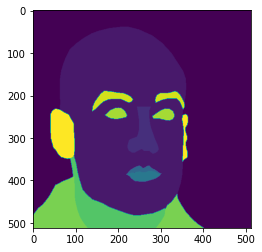

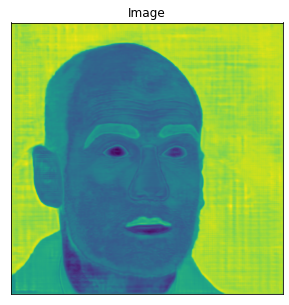

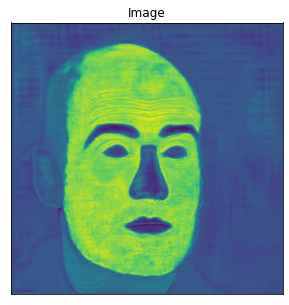

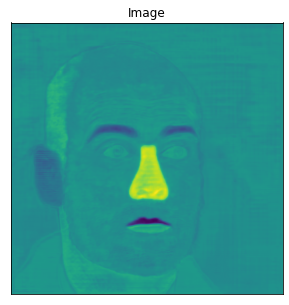

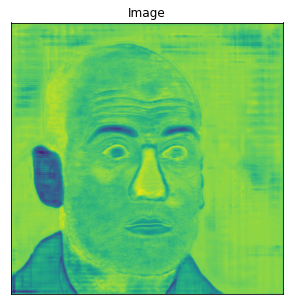

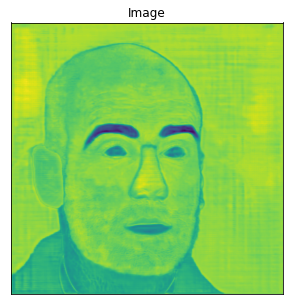

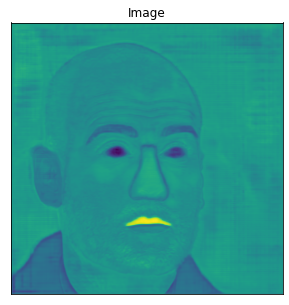

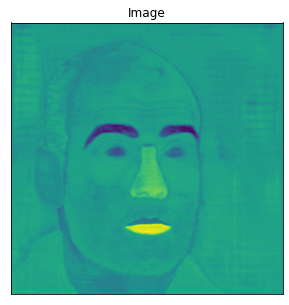

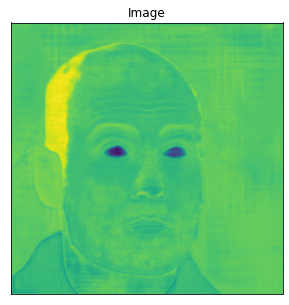

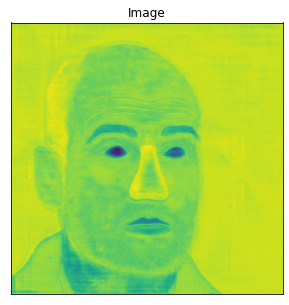

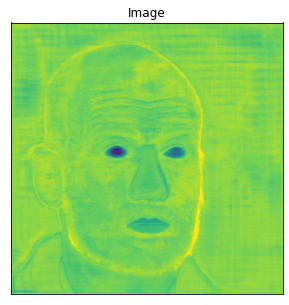

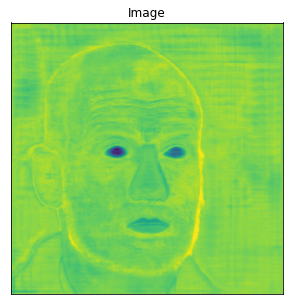

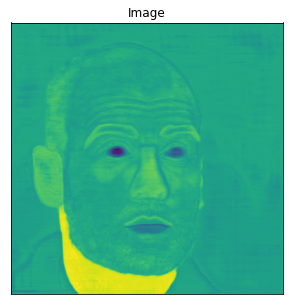

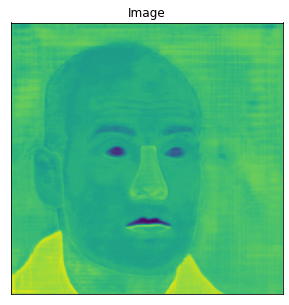

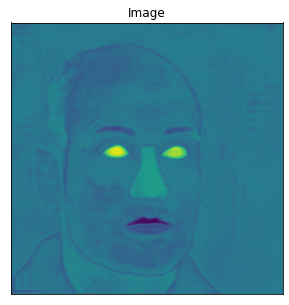

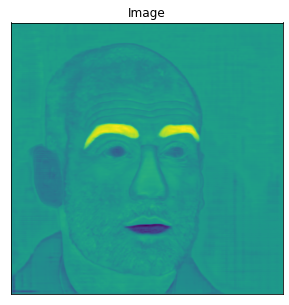

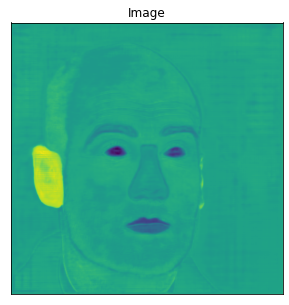

In [21]:
import matplotlib.pyplot as plt
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

train, test = load_split_train_test('../input/celebamaskhq/CelebAMask-HQ/CelebA-HQ-img', '../input/shatay-selebu-molu', batch_size = 16)
data,target = next(iter(test))
out = model(data.to(device))
out = out[0]
plt.imshow(target[0])
for i in range(16):
    image = out[i]
    visualize(image=image.cpu().detach().numpy())